<a href="https://colab.research.google.com/github/gauravkkaushik/Machine-Learning-and-python/blob/main/Shap_Value_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving train (1).csv to train (1).csv
Saving test.csv to test (1).csv


{'train (1).csv': b'PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked\r\n1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S\r\n2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C\r\n3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S\r\n4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S\r\n5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S\r\n6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q\r\n7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S\r\n8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S\r\n9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S\r\n10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C\r\n11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7,G6,S\r\n12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.55,C103,

# Imports

In [40]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

# Load Titanic Data

In [52]:
# 1. Load the dataset
# You can download 'train.csv' from the Kaggle Titanic competition
df = pd.read_csv('/content/train (1).csv')

# 2. Preprocessing
# Fill missing values and convert categories to numbers
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Define features (X) and target (y)
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
X = df[features]
y = df['Survived']

# Exploratory Data Analysis

## Unveiling the Patterns: An Exploratory Data Analysis of the Titanic

Before we invite a Machine Learning model to interpret the disaster, we must first listen to what the raw data tells us. EDA allows us to identify the "signals" in the noise

## Missing Values
Data is rarely perfect, and historical data even less so. Our first step is identifying what we *don't* know.


* **Cabin (77.1% missing):** The vast majority of cabin data is lost to history. This tells us the model cannot rely on specific room numbers to predict survival.


In [44]:
# Check for missing values
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
pd.concat([missing_data, missing_percentage], axis=1, keys=['Total', 'Percent'])

,Total,Percent
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


By looking at variables in isolation, we establish the "ground truth" of the voyage.



* **The Survival Rate:** Only **38.4%** of passengers in our dataset survived. This is our "Class Imbalance"—the model must work harder to find the survivors than to find the victims.
* **Demographics:** The ship was a vessel of the young. The largest demographic was passengers between **20 and 35 years old**, with a notable secondary spike for young children.

* **Gender:** The "Women and Children First" protocol was not just a suggestion; it was a reality. Females had a survival rate of **74%**, while males faced a grim **18.9%**.
* **Socio-Economic Class:** Survival was a luxury. **1st Class passengers** were nearly three times more likely to survive than those in **3rd Class**.

## Survival Count and Age Distribution

/tmp/ipython-input-2267985136.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, ax=axes[0], palette='RdBu')


Text(0.5, 1.0, 'Age Distribution of Passengers')

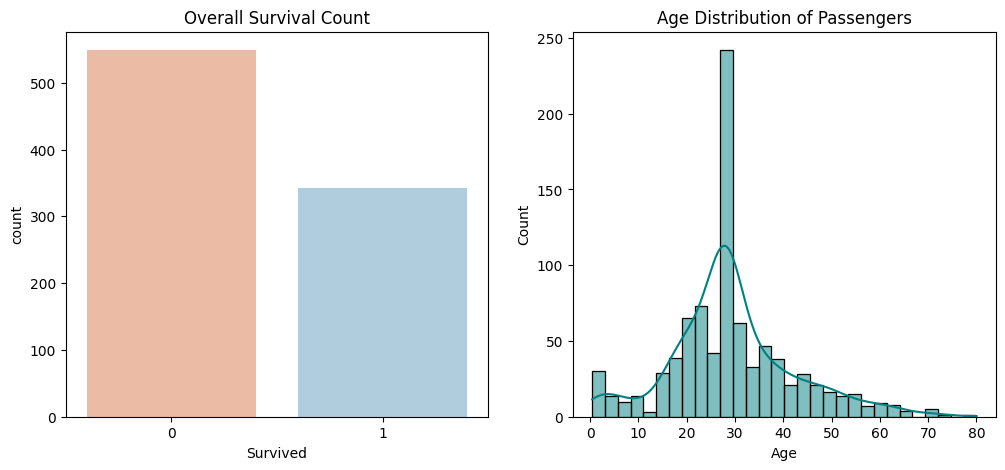

In [45]:
# Plotting distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Survival Count
sns.countplot(x='Survived', data=df, ax=axes[0], palette='RdBu')
axes[0].set_title('Overall Survival Count')

# Age Distribution
sns.histplot(df['Age'].dropna(), bins=30, kde=True, ax=axes[1], color='teal')
axes[1].set_title('Age Distribution of Passengers')

## 1. Survival by Gender

/tmp/ipython-input-762097399.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df, palette='coolwarm')


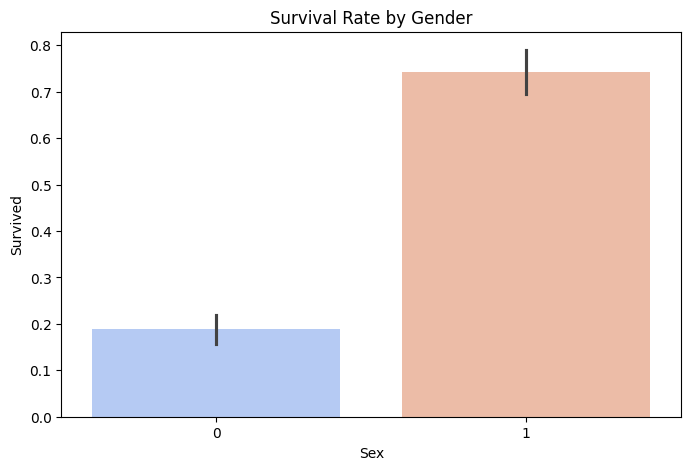

In [41]:
# 1. Survival by Gender
plt.figure(figsize=(8, 5))
sns.barplot(x='Sex', y='Survived', data=df, palette='coolwarm')
plt.title('Survival Rate by Gender')
plt.show()

## 2. Survival by Class

/tmp/ipython-input-1616644321.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=df, palette='viridis')


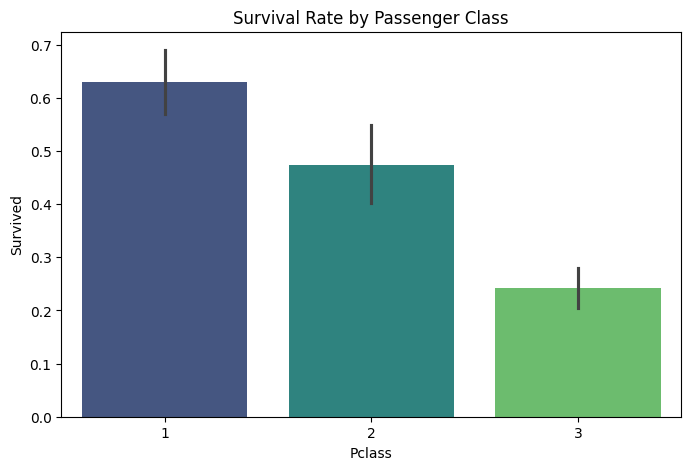

In [42]:
# 2. Survival by Class
plt.figure(figsize=(8, 5))
sns.barplot(x='Pclass', y='Survived', data=df, palette='viridis')
plt.title('Survival Rate by Passenger Class')
plt.show()

## 3. Age Distribution of Survivors vs Victims

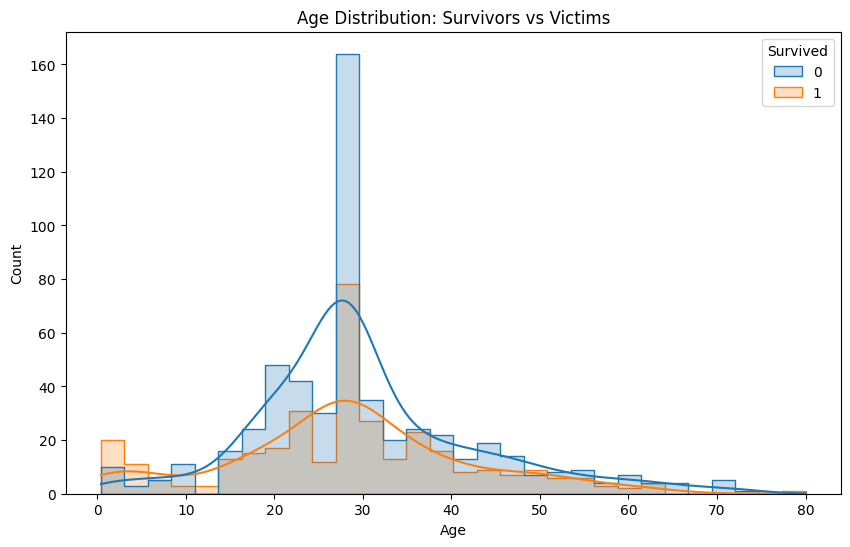

In [43]:
# 3. Age Distribution of Survivors vs Victims
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Survived', kde=True, element='step')
plt.title('Age Distribution: Survivors vs Victims')
plt.show()

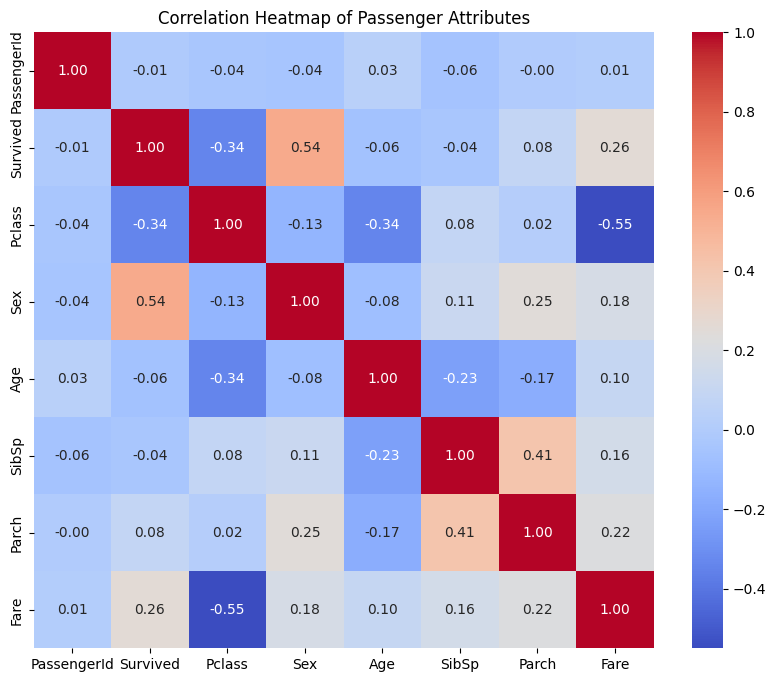

In [46]:
# Heatmap of numeric correlations
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Passenger Attributes')
plt.show()

## Correlation Heatmap

This helps us see how different features "move" together.

* **Pclass vs. Fare (-0.55):** A strong negative correlation. As the Class number goes down (towards 1st class), the Fare price goes up. This proves that Pclass is a perfect proxy for wealth.
* **Pclass vs. Survival (-0.34):** The strongest non-gender correlation. It confirms that as your class number increased (moving to steerage), your survival probability dropped.
* **SibSp & Parch (0.41):** These variables move together, identifying the family units on board. Traveling with a spouse usually meant traveling with children.


# Why this EDA matters for SHAP
Without this context, the SHAP values we calculate later would be just numbers. Because we know that **Sex** and **Class** have the strongest correlations with survival here, we can use SHAP to see if the model actually prioritizes them or if it finds "hidden" patterns we missed.

# Train a quick Model

In [16]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train a Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# SHAP

## Initialize SHAP

In [25]:

# 4. Initialize SHAP
# We use TreeExplainer specifically for tree-based models like Random Forest
explainer = shap.TreeExplainer(model)

print(f"Shape of X_test before shap_values calculation: {X_test.shape}")
print(f"Columns of X_test: {X_test.columns.tolist()}")

shap_values = explainer.shap_values(X_test)

print(f"Type of shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Length of shap_values list: {len(shap_values)}")
    for i, val in enumerate(shap_values):
        print(f"Shape of shap_values[{i}] (for class {i}): {val.shape}")
else:
    print(f"Shape of shap_values: {shap_values.shape}")

# NOTE: For Random Forest, shap_values is an array of shape (n_samples, n_features, n_classes).
# We want to explain 'Survived' (class 1), so we index the last dimension.
survived_shap_values = shap_values[:, :, 1] # Corrected indexing
print(f"Shape of survived_shap_values (shap_values[:, :, 1]): {survived_shap_values.shape}")


Shape of X_test before shap_values calculation: (179, 6)
Columns of X_test: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (179, 6, 2)
Shape of survived_shap_values (shap_values[:, :, 1]): (179, 6)


## VIZ 1: Summary Bar Plot

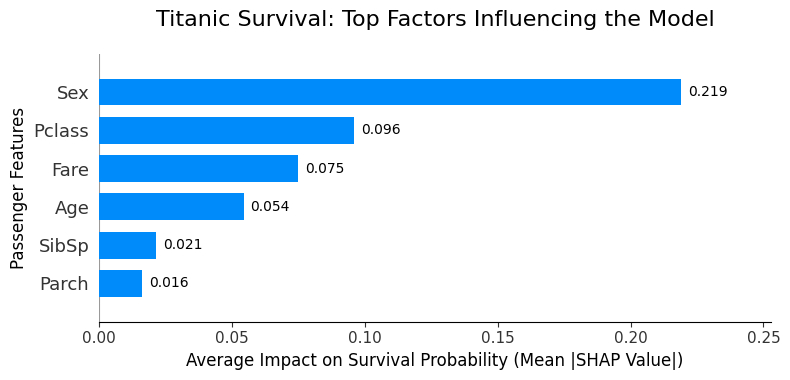

In [47]:
# --- VIZ 1: Summary Bar Plot with Bar Labels ---
plt.figure(figsize=(10, 6))

# 1. Generate the plot without immediately showing it
shap.summary_plot(survived_shap_values, X_test, plot_type="bar", show=False)

# 2. Access the current axes object
ax = plt.gca()

# 3. Add labels to the bars
# 'fmt="%.3f"' rounds the SHAP value to 3 decimal places
# 'padding=5' gives a little space between the bar and the text
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=5)

# 4. Adding custom labels and title
plt.title("Titanic Survival: Top Factors Influencing the Model", fontsize=16, pad=20)
plt.xlabel("Average Impact on Survival Probability (Mean |SHAP Value|)", fontsize=12)
plt.ylabel("Passenger Features", fontsize=12)

# 5. Adjust layout to ensure labels aren't cut off
# We increase the x-axis limit slightly to make room for the text labels
plt.xlim(0, ax.get_xlim()[1] * 1.1)

plt.tight_layout()
plt.show()

## VIZ 2: Beeswarm Plot

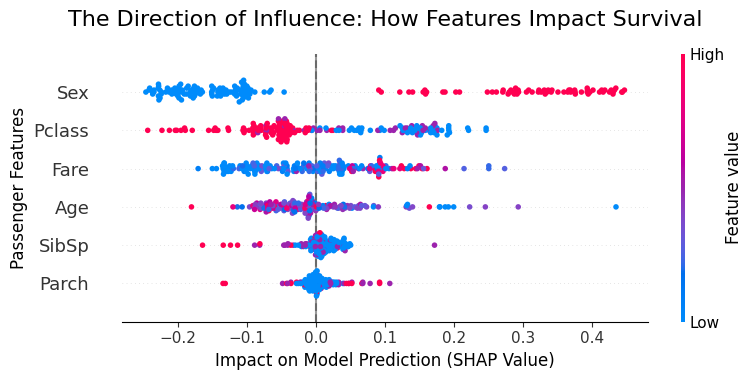

In [50]:
# --- VIZ 2: Beeswarm Plot with Custom Labels ---
plt.figure(figsize=(10, 6))

# 1. Create the plot (show=False is the key)
shap.summary_plot(survived_shap_values, X_test, show=False)

# 2. Add custom labels and title
plt.title("The Direction of Influence: How Features Impact Survival", fontsize=16, pad=20)
plt.xlabel("Impact on Model Prediction (SHAP Value)", fontsize=12)
plt.ylabel("Passenger Features", fontsize=12)

# 3. Polish the layout
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3) # Adds a vertical line at 0 for clarity
plt.tight_layout()
plt.show()

## The Global Summary: Decoding the Beeswarm Plot

The **Beeswarm Plot** is the "heart" of SHAP interpretability. It maps every passenger in our test set as a single dot, showing exactly how the model weighed their specific attributes.


### Key Interpretations:
* **The Direction of Survival:** Features to the **right** of the center line increased the probability of survival; features to the **left** decreased it.
* **The "Female" Advantage:** In the `Sex` row, we see a dramatic split. Red dots (Females) are clustered almost entirely on the right side. This confirms that gender was the single most influential "push" toward survival in the model's logic.
* **The 3rd Class Penalty:** Look at `Pclass`. High values (3rd Class) are colored red and pushed far to the left. This visualizes the grim reality that being in the lower class was a heavy statistical burden on survival.
* **Wealth as a Buffer:** The `Fare` row shows red dots (high fares) drifting toward the survival zone. Even when controlling for class, the model found that higher ticket prices generally correlated with better outcomes.
* **Feature Density:** The "thickness" of the clusters tells us where the majority of passengers lie. The thick blue cluster on the left for `Sex` represents the large number of men who were predicted not to survive based on that single trait.

> **Why this matters:** Unlike a simple bar chart, the Beeswarm plot shows us the *range* of effects. It reveals that some 3rd-class passengers (red dots) still managed to move toward the right, likely because their other features (like being female or a child) outweighed their class status.

## VIZ 3: Waterfall Plot (Individual Prediction)

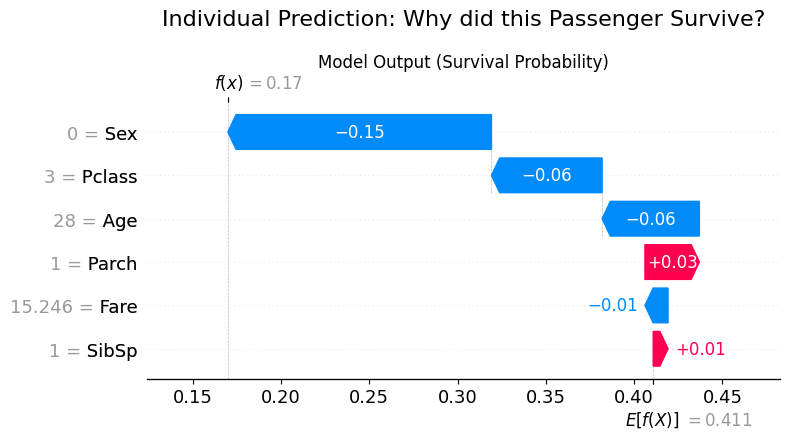

In [49]:
# --- VIZ 3: Waterfall Plot (Individual Prediction) ---
import matplotlib.pyplot as plt

# 1. Setup the figure size
plt.figure(figsize=(10, 6))

# 2. Generate the waterfall plot
# Note: show=False is critical to allow modifications
shap.plots.waterfall(shap_values_exp[0][:, 1], show=False)

# 3. Add custom labels and title
plt.title("Individual Prediction: Why did this Passenger Survive?", fontsize=16, pad=20)
plt.xlabel("Model Output (Survival Probability)", fontsize=12)

# 4. Final display
plt.tight_layout()
plt.show()

### Decoding a Single Prediction

While global plots show us the "average" logic of the Titanic, the **Waterfall Plot** allows us to zoom in on a single human story. It acts like a line-item receipt, showing exactly how the model arrived at a specific survival probability.


### How to Read the Waterfall:
* **The Starting Point ($E[f(X)]$):** At the bottom, we start with the "Base Value." This is the average survival rate across the entire ship (approx. 38%).
* **The Arrows:** Each row represents a feature of the passenger (e.g., they were in 3rd Class, they were Male).
    * **Red Arrows (Positive):** Features that increased the passenger's survival odds.
    * **Blue Arrows (Negative):** Features that decreased their survival odds.
* **The Final Score ($f(X)$):** The top of the plot shows the final predicted probability for this specific person.

### Insights from this Passenger:
In this specific case, we see a tragic "push and pull."
1. **Gender (Male):** This passenger’s gender provides the largest negative pull (blue arrow), dragging their survival probability down from the ship's average.
2. **Class (3rd Class):** Being in steerage further penalizes their score.
3. **Age (Young):** Although being young provides a positive "nudge" (red arrow), it is not powerful enough to overcome the massive disadvantages of their gender and class.

**Conclusion:** The waterfall plot proves that our model isn't just "guessing." It is weighing competing factors. It shows us that for this passenger, the historical reality of being a male in 3rd class was a hurdle that even youth could not overcome.

## VIZ 4: Dependence Plot (Age vs Survival)

<Figure size 1000x600 with 0 Axes>

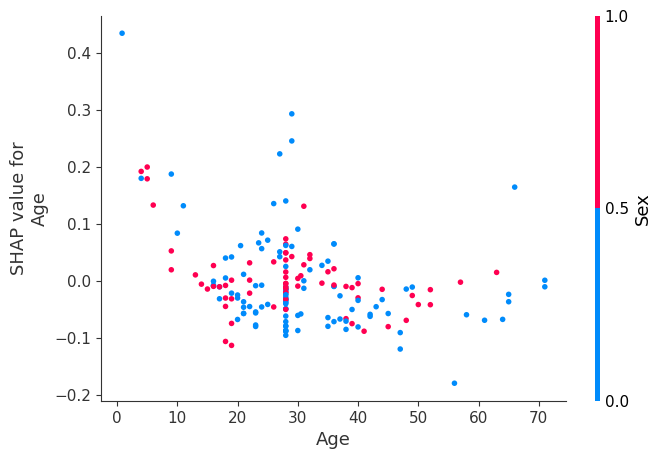

In [35]:
# --- VIZ 4: Dependence Plot (Age vs Survival) ---
plt.figure(figsize=(10, 6))
shap.dependence_plot("Age", survived_shap_values, X_test, interaction_index="Sex")

## Deep Dive: How Age and Gender Collide (SHAP Dependence)

Global importance tells us *that* Age matters, but the **SHAP Dependence Plot** reveals exactly *when* and *for whom* it matters. By plotting Age against its SHAP value, we can see the model's nuanced logic.

## Key Interpretations:
* **The "Childhood Bonus":** Passengers younger than 15 years old consistently receive a positive SHAP value. This is the model numerically representing the "children first" protocol.
* **The Survival Cliff:** There is a visible drop-off between ages 15 and 20. Once a passenger is categorized as an "adult" by the model, their age begins to act as a drag on their survival probability.
* **Gender Interaction:** The vertical spread of the dots at any given age reveals a hidden interaction. For example, at age 25, females (often colored red) sit higher on the Y-axis than males (colored blue). This proves that the model doesn't just look at age in a vacuum—it understands that being a 25-year-old woman was very different from being a 25-year-old man on that night.
* **Seniority Trends:** For the very elderly (60+), the points often dip further or scatter, suggesting that being a senior was a significant disadvantage, likely due to mobility issues during the evacuation.

> **Why this is better than a simple correlation:** A correlation would just say "older people died more." This plot shows us the specific thresholds where the model changes its mind about a passenger's fate.

## VIZ 5: Partial Dependence Plot (Age vs Survival)

<Figure size 1000x600 with 0 Axes>

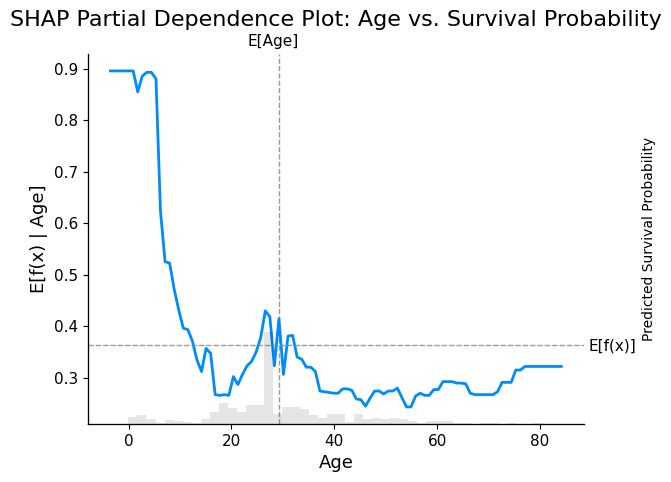

In [48]:
# --- VIZ 5: Partial Dependence Plot (Age vs Survival) ---
# We visualize the effect of 'Age' on the model's prediction
plt.figure(figsize=(10, 6))

shap.partial_dependence_plot(
    "Age",
    model.predict,
    X_train,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False # Set to True if you want to see Individual Conditional Expectation lines
)

plt.title("SHAP Partial Dependence Plot: Age vs. Survival Probability", fontsize=16)
plt.ylabel("Predicted Survival Probability")
plt.grid(True, alpha=0.3)
plt.show()

### SHAP Partial Dependence Analysis

While global importance tells us *that* Age matters, the **SHAP Partial Dependence Plot** tells us *how* it matters across the lifecycle of a passenger.


### Key Findings:
* **The Age Threshold:** The model identifies a clear "survival premium" for passengers under the age of 15. In this zone, the predicted probability of survival is significantly higher than the ship's average.
* **The Transition to Adulthood:** We observe a sharp decline in survival probability as passengers move from childhood into their late teens. By age 18, the "child bonus" completely evaporates, and the probability levels off.
* **Adult Plateau:** Between the ages of 20 and 50, the marginal effect of age remains relatively flat. This suggests that for adults, the model relies less on their specific age and more on other factors like Ticket Class or Gender.
* **The Value of Non-Linearity:** This plot proves that our Random Forest model isn't just treating Age as a simple number; it has successfully mapped the socio-historical reality that "children" were a distinct category with unique survival odds.

> **Technical Note:** The Partial Dependence Plot represents the average prediction of the model when we vary the Age feature across all passengers. It isolates the effect of Age from other variables like Fare or Class.